In [ ]:
import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'chest-xray-pneumonia:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F17810%2F23812%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240508%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240508T201721Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D066ba5ea60e399a8131618445035a742e13746e91a15d3fb619b071178f9e769975c6859e7b062e5d35707837532ed53d147c20702f4c547ca77a0a3081ed0634388f250a7acfa0884a1b34ea6f25960a412a8838a1319bc47b0b84763033b1137f3167ae1c27c43b9c1d429779ae66e5c66ec74d7f9b6893f32c793d75b0ab315af95ac9e7583faa485be956261b83e43e2c3573294648dd5cd2866c85a0b13351e5782ce6f7b6716e8044c1708889784d654960183987cd7f332d84461aa69438d47dfd4d415e76a3a62232d3c3a0549dd965f9a4824a4a6f7d36552be229402c47e12cec72fd9ab8c3de360634a94a2effe516d3c67e92c8701da333f52cb'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


In [ ]:
import os
import itertools
from PIL import Image

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix ,classification_report

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.layers import Dense ,Conv2D , Dropout,Flatten ,MaxPooling2D ,BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import warnings
warnings.filterwarnings("ignore")


print("modules loaded")

2024-05-08 19:59:36.331039: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-08 19:59:36.331146: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-08 19:59:36.451564: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


modules loaded


#Load Dataset#

In [ ]:
test_path="/kaggle/input/chest-xray-pneumonia/chest_xray/test/"
image_pathes=[]
labels=[]
files=os.listdir(test_path)
for file in files:
    file_bath=os.path.join(test_path,file)
    images=os.listdir(file_bath)
    for image in images:
        image_bath=os.path.join(file_bath , image)
        image_pathes.append(image_bath)
        labels.append(file)

Fseries =pd.Series(image_pathes,name="image_pathes")
lseries=pd.Series(labels,name="labels")

test_df=pd.concat([Fseries,lseries],axis=1)


In [ ]:
train_path="/kaggle/input/chest-xray-pneumonia/chest_xray/train/"
image_pathes=[]
labels=[]

files=os.listdir(train_path)
for file in files:
    file_path=os.path.join(train_path,file)
    images=os.listdir(file_path)
    for image in images:
        image_path=os.path.join(file_path,image)
        image_pathes.append(image_path)
        labels.append(file)

fseries=pd.Series(image_pathes, name="image_pathes")
lseries=pd.Series(labels,name="labels")
train_df=pd.concat([fseries,lseries],axis=1)


In [ ]:
val_path="/kaggle/input/chest-xray-pneumonia/chest_xray/val/"
image_pathes=[]
labels=[]

files=os.listdir(val_path)
for file in files:
    file_path=os.path.join(train_path,file)
    images=os.listdir(file_path)
    for image in images:
        image_path=os.path.join(file_path,image)
        image_pathes.append(image_path)
        labels.append(file)

fseries=pd.Series(image_pathes, name="image_pathes")
lseries=pd.Series(labels,name="labels")
valid_df=pd.concat([fseries,lseries],axis=1)

In [ ]:
batsh_size=16
image_size=(224,224)

df_gen=ImageDataGenerator()

train_gen=df_gen.flow_from_dataframe(train_df,x_col="image_pathes",y_col="labels",batsh_size=batsh_size,
                           target_size=image_size,class_mode="categorical" ,color_mode="rgb",shuffle=True )
test_gen=df_gen.flow_from_dataframe(test_df,x_col="image_pathes",y_col="labels",target_size=image_size
                                    ,batsh_size=batsh_size ,shuffle=True ,color_mode="rgb",class_mode="categorical")
valid_gen=df_gen.flow_from_dataframe(valid_df,x_col="image_pathes",y_col="labels",target_size=image_size
                                    ,batsh_size=batsh_size , shuffle=True ,color_mode="rgb" ,class_mode="categorical")

Found 5216 validated image filenames belonging to 2 classes.
Found 624 validated image filenames belonging to 2 classes.
Found 5216 validated image filenames belonging to 2 classes.


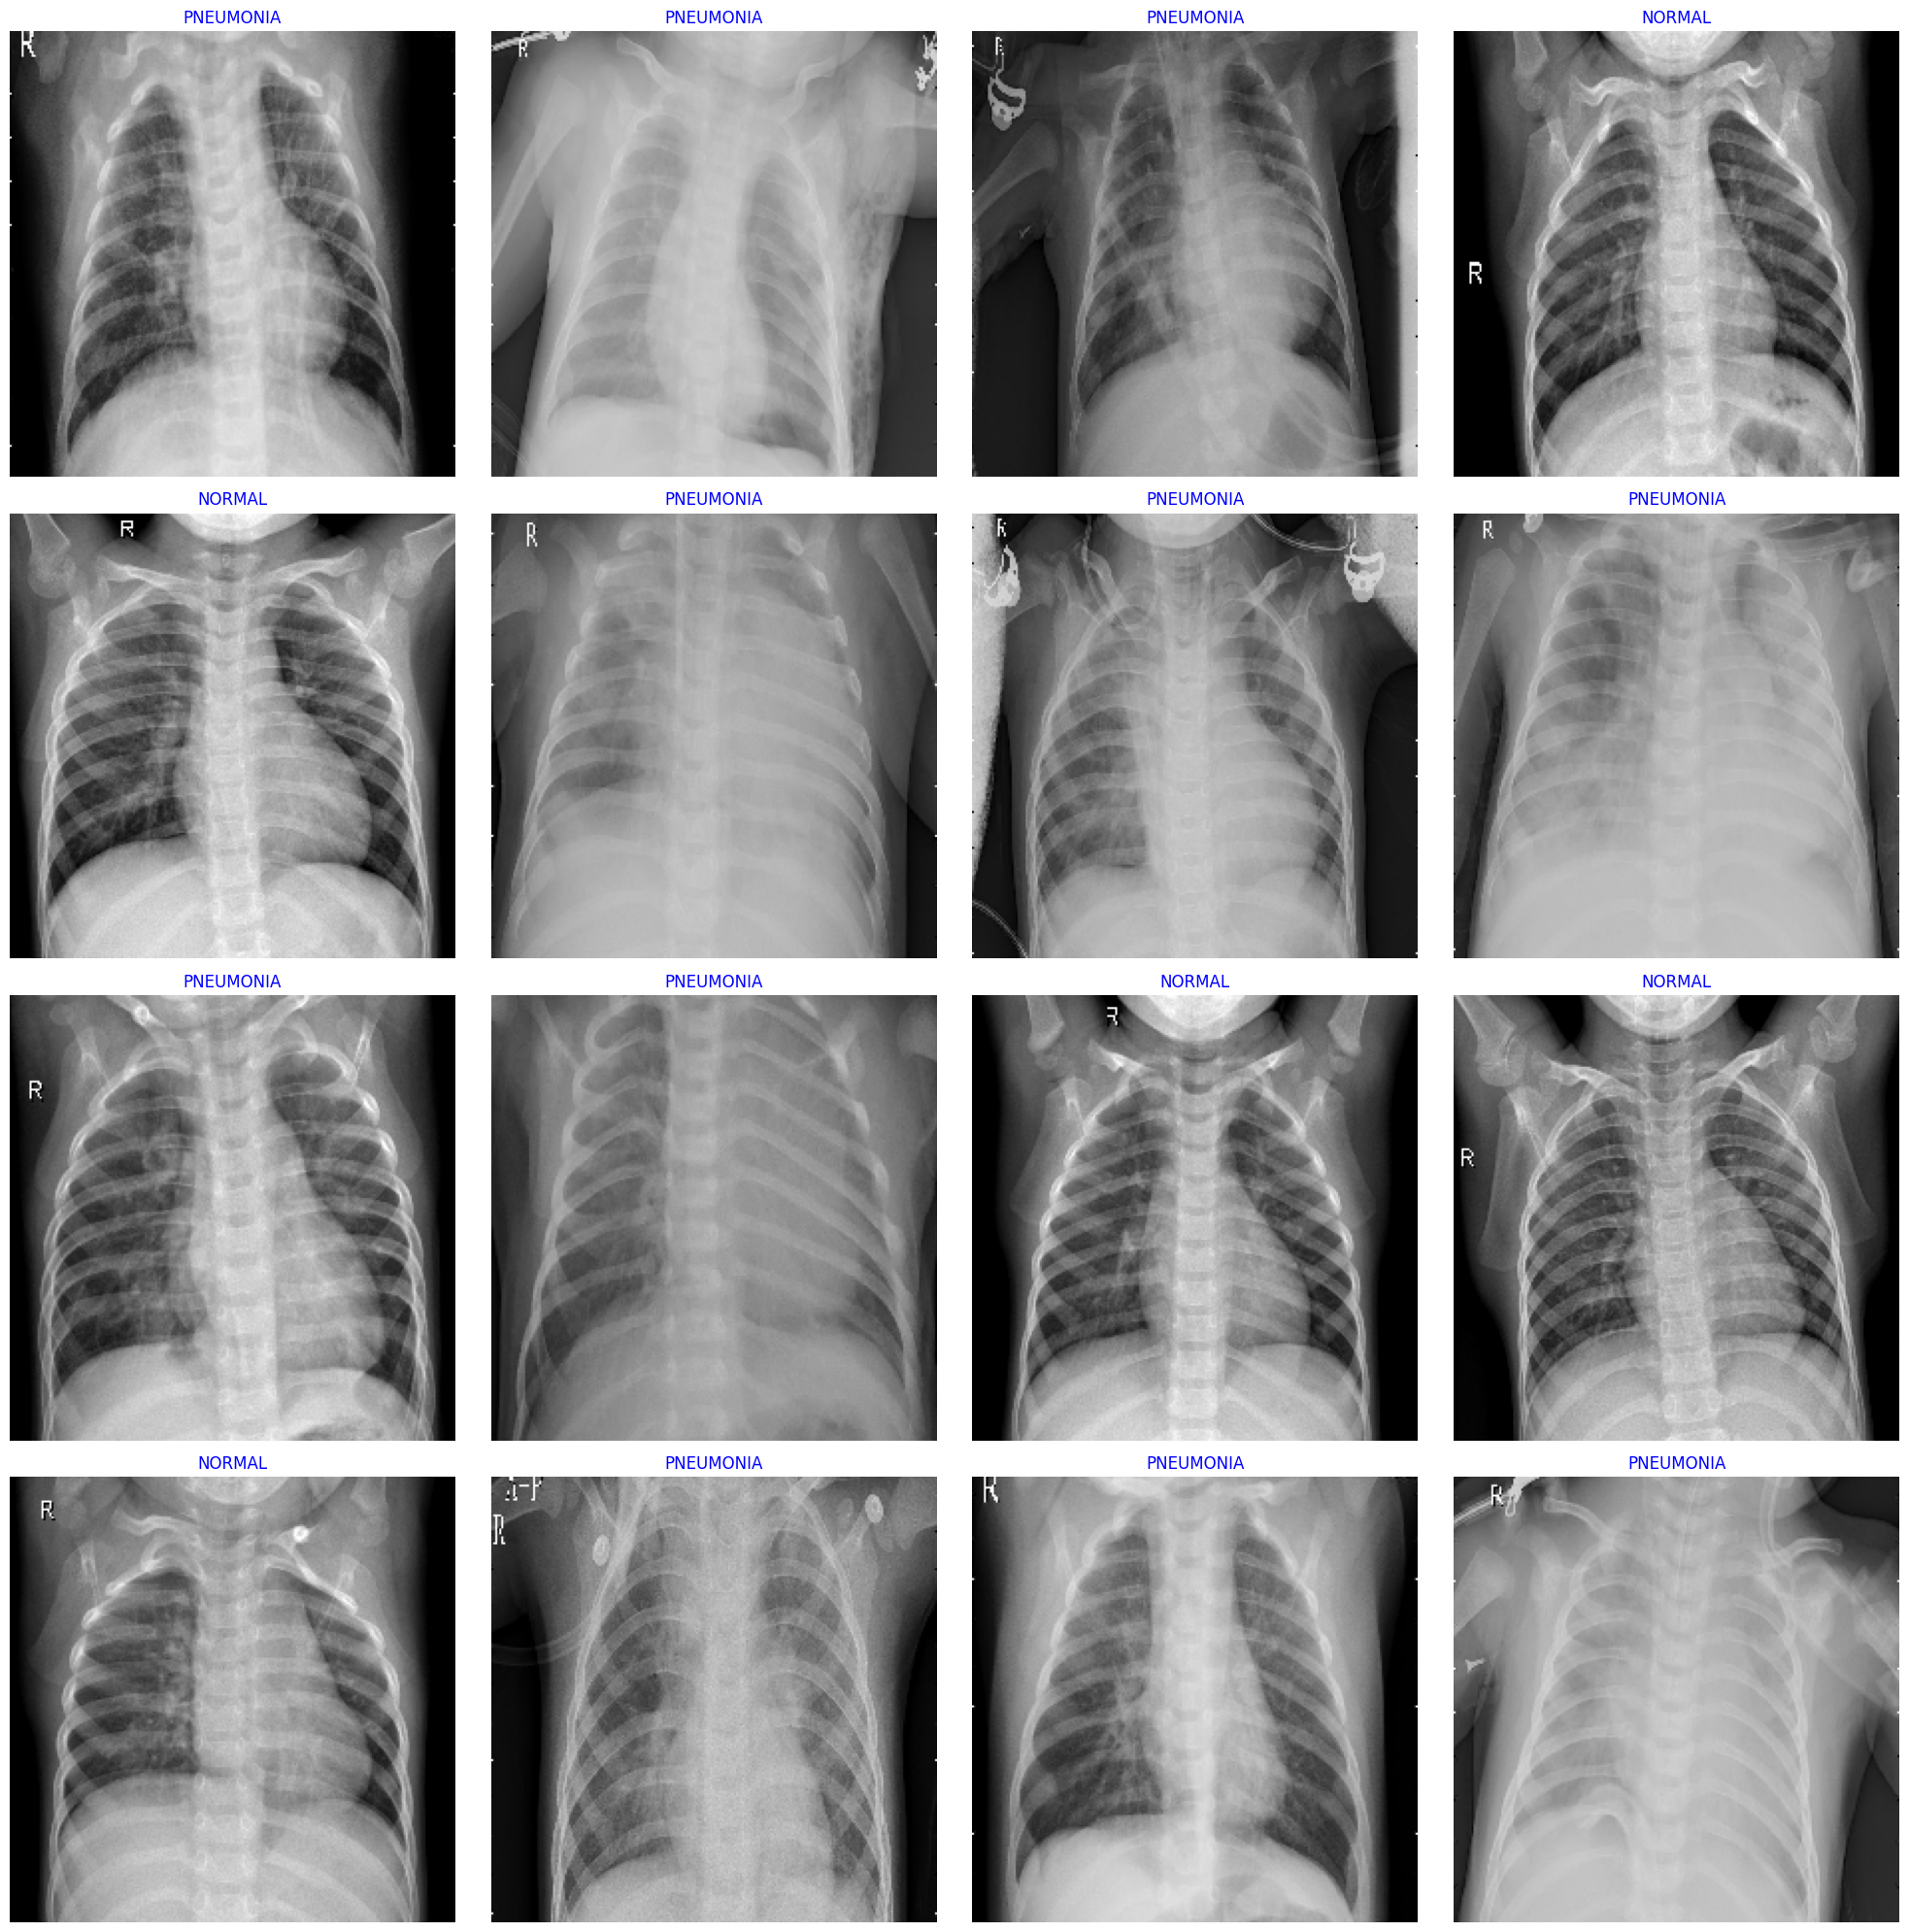

In [ ]:
g_dict = train_gen.class_indices
classes = list(g_dict.keys())
images, labels = next(train_gen)



plt.figure(figsize= (20, 20))

for i in range(16):
    plt.subplot(4,4, i + 1)
    image = images[i] / 255       # scales data to range (0 - 255)
    plt.imshow(image)
    index = np.argmax(labels[i])  # get image index
    class_name = classes[index]   # get class of image
    plt.title(class_name, color= 'blue', fontsize= 12)
    plt.axis('off')
plt.tight_layout()
plt.show()



#Define Customized Model#

In [ ]:
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)

class_count = len(list(train_gen.class_indices.keys())) # to define number of classes in dense layer

model = Sequential([
    Conv2D(filters=64, kernel_size=(3,3), padding="same", activation="relu", input_shape= img_shape),
    BatchNormalization(),
    Conv2D(filters=64, kernel_size=(3,3), padding="same", activation="relu"),
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"),
    BatchNormalization(),
    Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"),
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"),
    BatchNormalization(),
    Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"),
    BatchNormalization(),
    Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"),
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"),
    BatchNormalization(),
    Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"),
    BatchNormalization(),
    Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"),
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    Flatten(),
    Dropout(0.2),

    Dense(256,activation = "relu"),
    Dropout(0.2),
    Dense(64,activation = "relu"),
    Dropout(0.2),
    Dense(64,activation = "relu"),
    Dropout(0.2),
    Dense(class_count, activation = "softmax")
])

model.compile(Adamax(learning_rate= 0.001), loss= 'categorical_crossentropy', metrics= ['accuracy'])

model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_23 (Conv2D)              │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_22          │ (None, 224, 224, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_24 (Conv2D)              │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_23          │ (None, 224, 224, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_25 (Conv2D)              │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_24          │ (None, 112, 112, 128)  │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_26 (Conv2D)              │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_25          │ (None, 112, 112, 128)  │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_27 (Conv2D)              │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_26          │ (None, 56, 56, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_28 (Conv2D)              │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_27          │ (None, 56, 56, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_29 (Conv2D)              │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_28          │ (None, 56, 56, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_30 (Conv2D)              │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_29          │ (None, 28, 28, 512)    │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_31 (Conv2D)              │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_30          │ (None, 28, 28, 512)    │         2,04

 Total params: 33,357,122 (127.25 MB)

 Trainable params: 33,351,746 (127.23 MB)

 Non-trainable params: 5,376 (21.00 KB)

In [ ]:
epochs=8
history=model.fit(train_gen,epochs=epochs ,validation_data=valid_gen ,verbose=1)

Epoch 1/8


2024-05-08 20:00:12.686594: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 0: 4.63498, expected 3.85968
2024-05-08 20:00:12.686650: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 3: 6.55784, expected 5.78254
2024-05-08 20:00:12.686659: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 4: 6.61282, expected 5.83752
2024-05-08 20:00:12.686667: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 6: 6.34499, expected 5.56968
2024-05-08 20:00:12.686675: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 7: 6.25159, expected 5.47629
2024-05-08 20:00:12.686682: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 8: 5.43964, expected 4.66434
2024-05-08 20:00:12.686690: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 9: 6.54333, expected 5.76803
2024-05-08 20:00:12.686698: E external/local_xla/xla/se

163/163 ━━━━━━━━━━━━━━━━━━━━ 170s 717ms/step - accuracy: 0.8077 - loss: 2.4142 - val_accuracy: 0.7883 - val_loss: 5.4780
Epoch 2/8
163/163 ━━━━━━━━━━━━━━━━━━━━ 92s 550ms/step - accuracy: 0.9278 - loss: 0.3320 - val_accuracy: 0.9557 - val_loss: 0.1338
Epoch 3/8
163/163 ━━━━━━━━━━━━━━━━━━━━ 90s 541ms/step - accuracy: 0.9408 - loss: 0.2283 - val_accuracy: 0.9657 - val_loss: 0.2401
Epoch 4/8
163/163 ━━━━━━━━━━━━━━━━━━━━ 91s 545ms/step - accuracy: 0.9542 - loss: 0.1665 - val_accuracy: 0.9641 - val_loss: 0.1286
Epoch 5/8
163/163 ━━━━━━━━━━━━━━━━━━━━ 88s 530ms/step - accuracy: 0.9656 - loss: 0.1017 - val_accuracy: 0.8589 - val_loss: 1.5445
Epoch 6/8
163/163 ━━━━━━━━━━━━━━━━━━━━ 90s 539ms/step - accuracy: 0.9652 - loss: 0.0988 - val_accuracy: 0.9544 - val_loss: 0.1545
Epoch 7/8
163/163 ━━━━━━━━━━━━━━━━━━━━ 89s 538ms/step - accuracy: 0.9677 - loss: 0.0846 - val_accuracy: 0.7184 - val_loss: 1.7625
Epoch 8/8
163/163 ━━━━━━━━━━━━━━━━━━━━ 90s 542ms/step - accuracy: 0.9702 - loss: 0.0875 - val_accur

#Plot Accuracy#

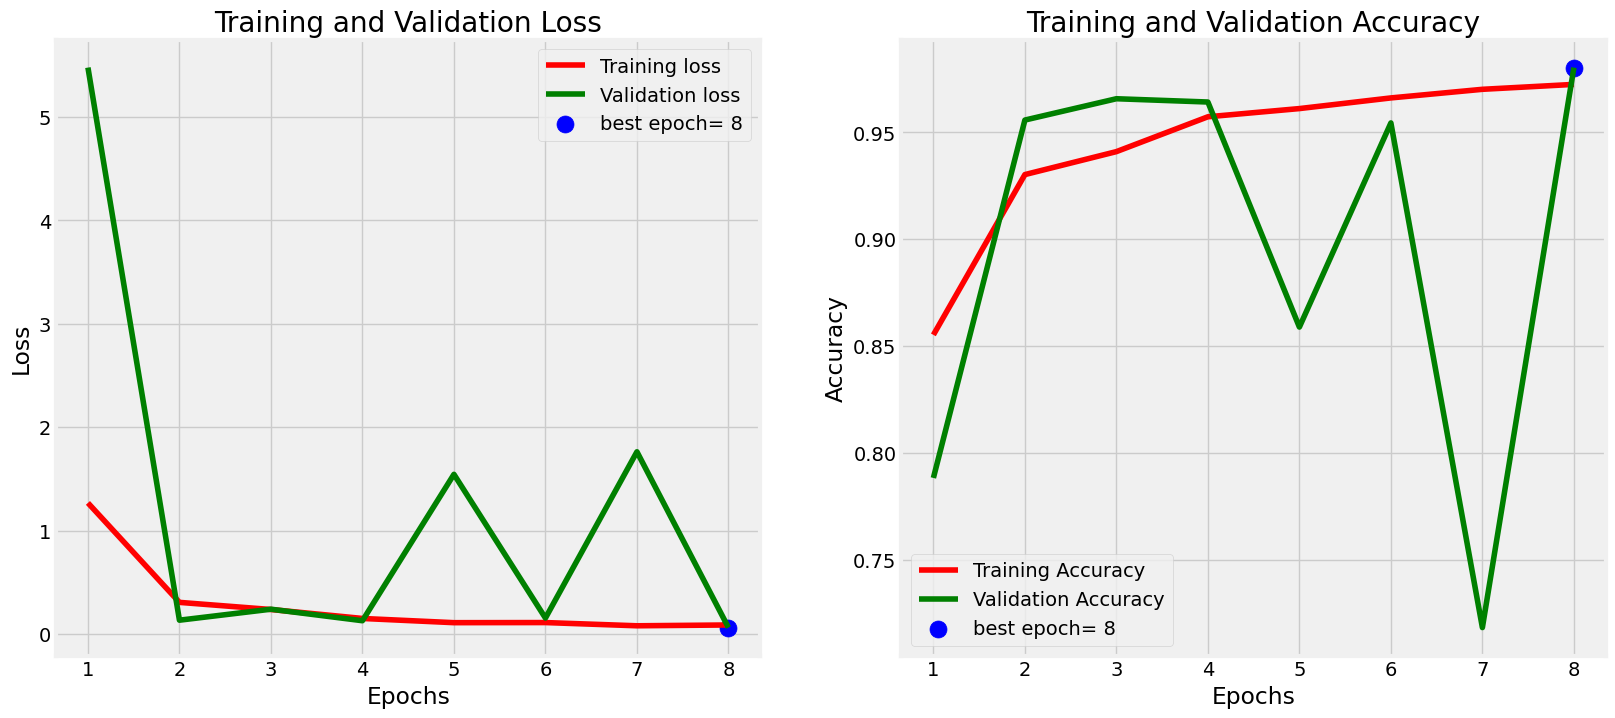

In [ ]:
 tr_acc = history.history['accuracy']
tr_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]

Epochs = [i+1 for i in range(len(tr_acc))]
loss_label = f'best epoch= {str(index_loss + 1)}'
acc_label = f'best epoch= {str(index_acc + 1)}'

# Plot training history
plt.figure(figsize= (20, 8))
plt.style.use('fivethirtyeight')

plt.subplot(1, 2, 1)
plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
plt.scatter(index_loss + 1, val_lowest, s= 150, label= loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
plt.scatter(index_acc + 1 , acc_highest, s= 150, label= acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout
plt.show()

In [ ]:
train_score=model.evaluate(train_gen , verbose=1)
valid_score=model.evaluate(valid_gen , verbose=1)
test_score=model.evaluate(test_gen , verbose=1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("valid Loss: ", valid_score[0])
print("valid Accuracy: ", valid_score[1])
print('-' * 20)
print("test Loss: ", test_score[0])
print("test Accuracy: ", test_score[1])
print('-' * 20)

163/163 ━━━━━━━━━━━━━━━━━━━━ 44s 270ms/step - accuracy: 0.9773 - loss: 0.0551
163/163 ━━━━━━━━━━━━━━━━━━━━ 43s 266ms/step - accuracy: 0.9818 - loss: 0.0564
19/20 ━━━━━━━━━━━━━━━━━━━━ 0s 364ms/step - accuracy: 0.7578 - loss: 1.9310

2024-05-08 20:14:53.794815: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 0: 3.89842, expected 3.37692
2024-05-08 20:14:53.794873: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 12: 3.13412, expected 2.61262
2024-05-08 20:14:53.794883: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 13: 3.08377, expected 2.56227
2024-05-08 20:14:53.794891: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 14: 4.1021, expected 3.5806
2024-05-08 20:14:53.794899: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 29: 3.76539, expected 3.24388
2024-05-08 20:14:53.794907: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 30: 4.19841, expected 3.6769
2024-05-08 20:14:53.794914: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 63: 3.88366, expected 3.36216
2024-05-08 20:14:53.794922: E external/local_xla/xla

20/20 ━━━━━━━━━━━━━━━━━━━━ 16s 815ms/step - accuracy: 0.7550 - loss: 1.9671
Train Loss:  0.06231203302741051
Train Accuracy:  0.9802530407905579
--------------------
valid Loss:  0.0623120442032814
valid Accuracy:  0.9802530407905579
--------------------
test Loss:  2.3104474544525146
test Accuracy:  0.7291666865348816
--------------------


In [ ]:
preds = model.predict(test_gen)

y_pred = np.argmax(preds , axis = 1)

20/20 ━━━━━━━━━━━━━━━━━━━━ 6s 269ms/step


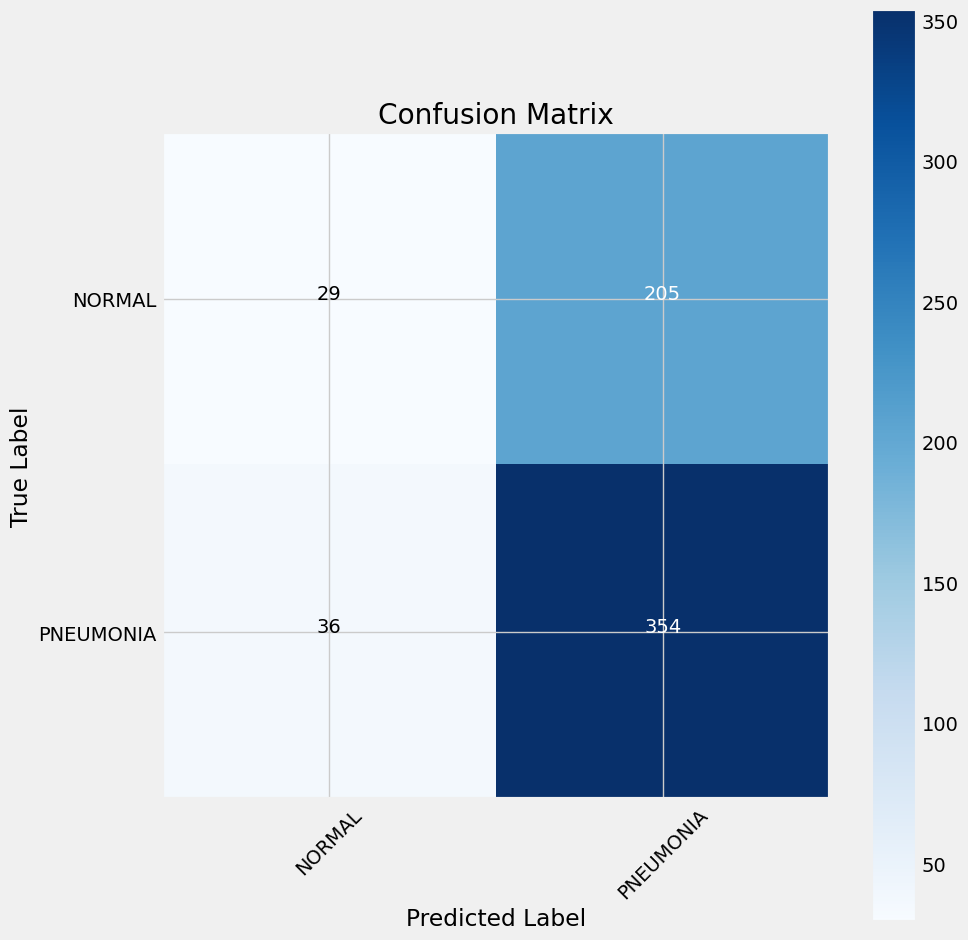

In [ ]:
g_dict = test_gen.class_indices
classes = list(g_dict.keys())

# Confusion matrix
cm = confusion_matrix(test_gen.classes, y_pred)

plt.figure(figsize= (10, 10))
plt.imshow(cm, interpolation= 'nearest', cmap= plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation= 45)
plt.yticks(tick_marks, classes)


thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment= 'center', color= 'white' if cm[i, j] > thresh else 'black')

plt.tight_layout()
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

plt.show()

In [ ]:
print(classification_report(test_gen.classes, y_pred , target_names= classes ))

              precision    recall  f1-score   support

      NORMAL       0.45      0.12      0.19       234
   PNEUMONIA       0.63      0.91      0.75       390

    accuracy                           0.61       624
   macro avg       0.54      0.52      0.47       624
weighted avg       0.56      0.61      0.54       624

